In [1]:
# Torch and related packages
import torch
from torchvision import transforms, datasets, utils
import torch.nn.functional as F
from PIL import Image

# Math and plot utils
import numpy as np
import matplotlib.pyplot as plt

# Useful utilities
import os
import random
import sys
import time
import copy
import glob

# Our model which we train
from models.fast_scnn_up import FastSCNN

In [2]:
gpuid = 0
print(torch.cuda.get_device_properties(gpuid))
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')
print(device)

_CudaDeviceProperties(name='GeForce GTX 1070 with Max-Q Design', major=6, minor=1, total_memory=8119MB, multi_processor_count=16)
cuda:0


In [3]:
class IGVCDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, labels_dir, transform=None):
        self.imgs_dir = imgs_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.files_names = os.listdir(imgs_dir)
        
    def __len__(self):
        return len(self.files_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.files_names[idx])
        label_path = os.path.join(self.labels_dir, self.files_names[idx])
        
        img = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('1')
        seed = random.randrange(sys.maxsize)
        if self.transform:
            random.seed(seed)
            img = self.transform(img)
            random.seed(seed)
            label = self.transform(label)
        
        img = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img)
        return img, label

In [4]:
def show_lanes(image, label):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    label = label.numpy().transpose((1, 2, 0))
    label = std * label + mean
    label = np.clip(label, 0, 1)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap='jet', alpha=0.5)
    plt.pause(0.001)

In [5]:
# lane_dataset = IGVCDataset(imgs_dir='data_train/images', labels_dir='data_train/labels')
# lane_dataset = IGVCDataset(imgs_dir='data_train/images', labels_dir='data_train/labels', transform=train_transforms)
# fig = plt.figure()
# for i in range(len(lane_dataset)):
#     img, label = lane_dataset[i]

#     print(i, img.size(), label.size())

#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     show_lanes(img, label)
#     if i == 3:
#         plt.show()
#         break

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=240),
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], 
#                          std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], 
#                          std=[0.5, 0.5, 0.5])

])

In [7]:
dataloaders = {}
datasets = {}
datasizes = {}

datasets['train'] = IGVCDataset(imgs_dir='data_train/images', labels_dir='data_train/labels', transform=train_transforms)
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=4)
datasizes['train'] = len(datasets['train'])

datasets['val'] = IGVCDataset(imgs_dir='data_val/images', labels_dir='data_val/labels', transform=test_transforms)
dataloaders['val'] = torch.utils.data.DataLoader(datasets['val'], batch_size=4, shuffle=True, num_workers=2)
datasizes['val'] = len(datasets['val'])

datasets['test'] = IGVCDataset(imgs_dir='data_test/images', labels_dir='data_test/labels', transform=test_transforms)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=4, shuffle=False, num_workers=2)
datasizes['test'] = len(datasets['test'])

print(datasizes)

{'train': 265, 'val': 201, 'test': 434}


In [8]:
# dataiter = iter(dataloaders['train'])
# img, label = dataiter.next()
# show_lanes(utils.make_grid(img), utils.make_grid(label))
# plt.show()

In [9]:
def train_net(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long()[:, -1, :, :]
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(input=outputs, target=labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [10]:
fastscnn_model = FastSCNN(in_channel=3, num_classes=2).to(device)

In [11]:
optimizer_ft = torch.optim.SGD(fastscnn_model.parameters(), lr=0.003, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([1, 80], dtype=torch.float).to(device))

In [12]:
trained_model = train_net(fastscnn_model, dataloaders, datasizes, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)
print('done')

Epoch 0/14
----------
train Loss: 0.5153 Acc: 184354.5736
val Loss: 0.4500 Acc: 267115.6468

Epoch 1/14
----------
train Loss: 0.3431 Acc: 267973.1623
val Loss: 0.4049 Acc: 255361.5423

Epoch 2/14
----------
train Loss: 0.3036 Acc: 268558.9057
val Loss: 0.3866 Acc: 251262.0995

Epoch 3/14
----------
train Loss: 0.2728 Acc: 267676.6717
val Loss: 0.3525 Acc: 250525.4129

Epoch 4/14
----------
train Loss: 0.2444 Acc: 271137.6189
val Loss: 0.3296 Acc: 271422.7562

Epoch 5/14
----------
train Loss: 0.2449 Acc: 269045.2528
val Loss: 0.3278 Acc: 272584.8209

Epoch 6/14
----------
train Loss: 0.2355 Acc: 270213.1698
val Loss: 0.2724 Acc: 271180.4925

Epoch 7/14
----------
train Loss: 0.2215 Acc: 271215.2226
val Loss: 0.2677 Acc: 275019.8209

Epoch 8/14
----------
train Loss: 0.2139 Acc: 274458.8226
val Loss: 0.2513 Acc: 273193.9602

Epoch 9/14
----------
train Loss: 0.2166 Acc: 273806.3774
val Loss: 0.2578 Acc: 274821.7065

Epoch 10/14
----------
train Loss: 0.2280 Acc: 272499.5132
val Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


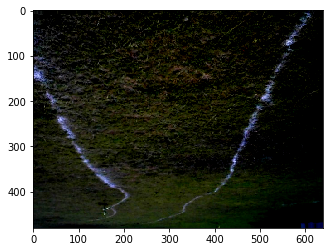

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


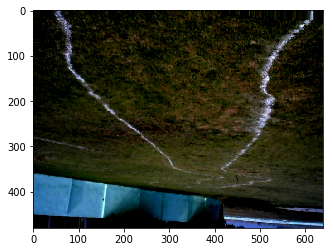

In [90]:
dataiter = iter(dataloaders['test'])
img, label = dataiter.next()
img, label = dataiter.next()
plt.imshow(img[1].permute(1,2,0))
#show_lanes(utils.make_grid(img), utils.make_grid(label))
plt.show()
plt.imshow(img[2].permute(1,2,0))
#show_lanes(utils.make_grid(img), utils.make_grid(label))
plt.show()

torch.Size([4, 2, 480, 640])


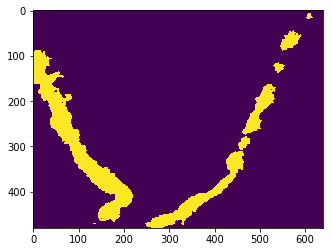

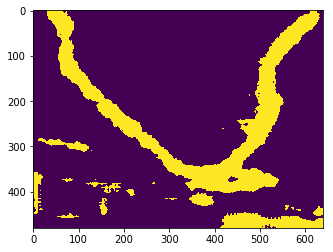

In [91]:
with torch.no_grad():
    img = img.to(device)
    output = trained_model(img)
    print(output.shape)
    pred = torch.argmax(output, 1).detach().cpu()
    plt.imshow(pred[1])
    plt.show()
    plt.imshow(pred[2])
    plt.show()
    #plt.imshow(img[0].detach().cpu().permute(1, 2, 0))

In [28]:
with torch.no_grad():
    start_time = time.time()
    dataiter = iter(dataloaders['test'])
    for i in range(100):
        if i == 0:
            lat_1 = time.time()
            
        img, label = dataiter.next()
        img = img.to(device)
        output = trained_model(img)
        pred = torch.argmax(output, 1).detach().cpu()
        
        if i == 0:
            lat_2 = time.time()
            
    end_time = time.time()

print('Results are as following. Tested on GTX 1070 Max-Q.')
print('Time for 400 Images : ', end_time - start_time, 'seconds')
print('FPS (GTX 1070 Max Q) : ', 400/(end_time - start_time), 'fps')
print('Latency : ', lat_2 - lat_1, 'seconds')

Results are as following. Tested on GTX 1070 Max-Q.
Time for 400 Images :  3.7572619915008545 seconds
FPS (GTX 1070 Max Q) :  106.46050259599232 fps
Latency :  0.1099081039428711 seconds


In [29]:
import time

In [30]:
for i in range(100):
        if i == 0:
            lat_1 = time.time()
        if i == 0:
            lat_2 = time.time()
print('Latency : ', lat_2 - lat_1)

Latency :  4.76837158203125e-07


In [31]:
torch.save(trained_model.state_dict(), './model_up')

In [116]:
img = Image.open('./img.jpg').convert('RGB')

In [117]:
test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

In [118]:
img = test_transforms(img)
img = img.unsqueeze(0).to(device)

In [119]:
label = trained_model(img)

In [120]:
pred = torch.argmax(label, 1).detach().cpu()

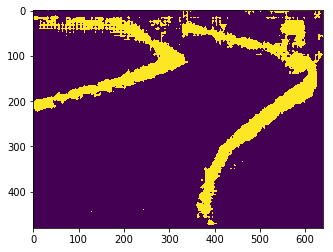

In [121]:
plt.imshow(pred[0])
plt.show()

In [68]:
# def visualize(img, out):
#     img = img.cpu().numpy()
#     _, pred = torch.max(out, 1)
#     pred = pred.cpu().numpy()
#     for i in range(1):
#         print(img[0].shape)
#         img_tmp = Image.fromarray(img[i], 'RGB')
#         #img_tmp.show()
#         pred_tmp = Image.fromarray(pred[i], '1')
#         pred_tmp.show()

In [20]:
# visualize(img, output)

In [21]:
# preds = preds.cpu()

In [22]:
# preds_0 = preds[0].squeeze(0).cpu().data.numpy()